### Problem 2:

In [1]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
import torchvision
import torchvision.transforms
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
import pprint

In [2]:
class Classifier(nn.Module):
    """Convnet Classifier"""
    def __init__(self, feature_maps, dropouts):
        super(Classifier, self).__init__()
        self.feature_maps = feature_maps
        self.dropouts = dropouts
        layers = self.layer(1,feature_maps[0], dropouts[0])+self.layer(feature_maps[0],feature_maps[1], dropouts[1])+self.layer(feature_maps[1],feature_maps[2], dropouts[2])+self.layer(feature_maps[2],feature_maps[3], dropouts[3])+self.layer(feature_maps[3],feature_maps[4], dropouts[4])
        self.conv = nn.Sequential(*layers)
        self.clf = nn.Linear(feature_maps[-1], 10)
        self.drop = nn.Dropout(p=0.4)
        
        
        
    def layer(self, i, o, dropout=0.1):
        return [nn.Conv2d(in_channels=i, out_channels=o, kernel_size=(4, 4), padding=2),
                #nn.BatchNorm2d(o),
                nn.Dropout(p=dropout),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2), stride=2)]
    
    def num_parameters(self):
        pars = 0
        for a,b in zip([1] + self.feature_maps, self.feature_maps):
            current_layer_parameters = a * 16 * b
            pars = pars + current_layer_parameters
        pars = pars + self.feature_maps[-1] * 10
        print("we have ", float(pars)/1000000, " million parameters") # Ignore biases
    
    def forward(self, x):
        x = self.conv(x)
        y = x.squeeze()
        return self.clf(self.drop(y))

In [3]:
perf = {}

torch.manual_seed(0)
mnist_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, transform=mnist_transforms, download=True)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, transform=mnist_transforms, download=True)

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True, num_workers=2)

cuda_available = torch.cuda.is_available()
print("Cuda available: %s" % cuda_available)
feature_maps = [[20,40,60,80,128], [20,40,60,50,40], [20,40,50,60,70]]
dropouts = [[0, 0.1, 0.1, 0.1,0.1 ], [0, 0.4, 0.4, 0.1,0.1 ], [0, 0.1, 0.5, 0.1,0.5 ]]
for feature_map in feature_maps:
    for dropout in dropouts:
        hyper = str(feature_map)+" "+str(dropout)
        print(hyper)
        perf[hyper] = []
        clf = Classifier(feature_map, dropout)
        clf.num_parameters()
        if cuda_available:
            clf = clf.cuda()
        optimizer = torch.optim.Adam(clf.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss() #  LogSoftmax and NLLLoss

        for epoch in range(10):
            # Train
            current_epoch_loss = []
            for batch_idx, (inputs, targets) in enumerate(train_loader):
                if cuda_available:
                    inputs, targets = inputs.cuda(), targets.cuda()

                optimizer.zero_grad()
                loss = criterion(clf(inputs), targets)
                loss.backward()
                optimizer.step()
                current_epoch_loss.append(loss.item())
            myLoss =  np.mean(current_epoch_loss)
            
            #    if batch_idx%500==0:
            #       print('Epoch : %d, Loss : %.3f ' % (epoch, np.mean(losses)))
            
            # Evaluate
            clf.eval()
            total = 0
            correct = 0
            for batch_idx, (inputs, targets) in enumerate(test_loader):
                if cuda_available:
                    inputs, targets = inputs.cuda(), targets.cuda()
                outputs = clf(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += predicted.eq(targets.data).cpu().sum()
            accur = 100*float(correct)/total    
            #print('Epoch : %d, Test Accuracy : %.2f%%, number of tests : %d' % (epoch, accur, total))
            #print('--------------------------------------------------------------')
            clf.train()
            perf[hyper].append((accur, myLoss))
        print(perf[hyper])


        
 


Processing...
Done!
Cuda available: False
[20, 40, 60, 80, 128] [0, 0.1, 0.1, 0.1, 0.1]
we have  0.29344  million parameters
[(97.83, 0.32906406849964276), (98.86, 0.07850550140327672), (98.41, 0.052008200776395896), (99.24, 0.0432359680835245), (99.15, 0.03726691778884259), (99.11, 0.031148918564798737), (99.22, 0.027646450482721904), (99.39, 0.023994634023257917), (99.29, 0.023962631770002563), (99.3, 0.019896410761087308)]
[20, 40, 60, 80, 128] [0, 0.4, 0.4, 0.1, 0.1]
we have  0.29344  million parameters
[(98.19, 0.33152414017370835), (98.33, 0.09417235039905317), (99.12, 0.07096778688980128), (99.09, 0.05507851247864364), (99.4, 0.05142397920031156), (99.29, 0.04497131878045449), (99.17, 0.042224169792190416), (99.34, 0.0385970377953036), (99.28, 0.034625441999609534), (99.35, 0.03376756852635665)]
[20, 40, 60, 80, 128] [0, 0.1, 0.5, 0.1, 0.5]
we have  0.29344  million parameters
[(98.35, 0.3592894788978419), (98.76, 0.0948590826946122), (99.03, 0.06879627885126165), (99.11, 0.0563

# we select the  top combination of hyperparameters in the following:  
and further plot the training error and validation accuracy for the ten epochs. The training error for each epoch indicates the mean of all the losses at each step during that epoch. 

In [4]:
best_performance = max(perf.values(), key=lambda x: max([a[0] for a in x]))
best_accuracy = [x[0] for x in best_performance]
best_loss = [x[1] for x in best_performance]


In [5]:
def plotThis(x, label ):
    xnew = np.linspace(np.arange(x.shape[0]).min(),np.arange(x.shape[0]).max(),300)
    spl = make_interp_spline(np.arange(x.shape[0]),x, k=3)
    power_smooth = spl(xnew)
    xx = plt.plot(xnew,power_smooth, label = label)


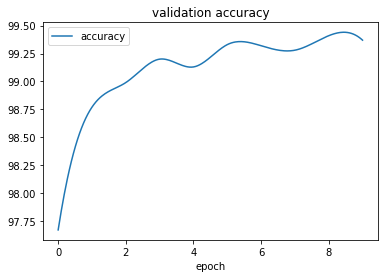

In [6]:
plotThis(np.array(best_accuracy), "accuracy")

plt.title("validation accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

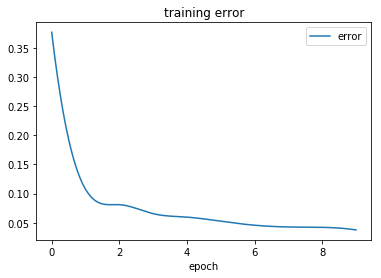

In [7]:
plotThis(np.array(best_loss), "error")

plt.title("training error")
plt.legend()
plt.xlabel("epoch")
plt.show()

We have lowered the dropout from p=0.5 to p=0.1 or p=0.4 for various convolutional layers. This was inspired by Park et.al (Analysis on the Dropout Effect in Convolutional Neural Networks), and didn't affect the generalization negatively. The dropout rate the first layer has been set to 0 for the same reason.
We also compared the dropout results with batch normalization, and found no improvements with batch normalization.